# DCGAN MNIST

Note: This notebook is designed to run with GPU runtime.

Import modules and set random seeds.

In [ ]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.datasets import mnist

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the MNIST dataset and store into NumPy arrays.

**MNIST データセットの代わりに、Fashion MNIST データセットをダウンロードします。**

In [ ]:
from tensorflow.keras.datasets import fashion_mnist # この行を変更

(train_images, train_labels), _ = fashion_mnist.load_data() # この行を変更
train_images = np.pad(train_images, ((0, 0), (2, 2), (2, 2)))
train_images = train_images.reshape(
                    (len(train_images), 32*32)).astype('float32') / 255

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Define a generator model with transoposed convolutional filters.

In [ ]:
latent_dim = 64

generator = models.Sequential(name='generator')
generator.add(layers.Input(shape=(latent_dim,), name='generator_input'))
generator.add(layers.Dense(4 * 4 * 128, name='expand'))
generator.add(layers.Reshape((4, 4, 128), name='reshape'))
generator.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same',
                                     name='conv_transpose1'))  # (8, 8, 64)
generator.add(layers.LeakyReLU(negative_slope=0.2, name='leaky_relu1'))
generator.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same',
                                     name='conv_transpose2'))  # (16, 16, 32)
generator.add(layers.LeakyReLU(negative_slope=0.2, name='leaky_relu2'))
generator.add(layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same',
                activation='sigmoid', name='conv_transpose3')) # (32, 32, 1)
generator.add(layers.Flatten(name='flatten'))

generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ expand (Dense)                       │ (None, 2048)                │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_transpose1 (Conv2DTranspose)    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_relu1 (LeakyReLU)              │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_transpose2 (Conv2DTranspose)    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_relu2 (LeakyReLU)              │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_transpose3 (Conv2DTranspose)    │ (None, 32, 32, 1)           │             289 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,665 (881.50 KB)

 Trainable params: 225,665 (881.50 KB)

 Non-trainable params: 0 (0.00 B)

Define a discriminator model with convolutional filters.

In [ ]:
discriminator = models.Sequential(name='discriminator')
discriminator.add(layers.Input(shape=(32*32,), name='discriminator_input'))
discriminator.add(layers.Reshape((32, 32, 1), name='reshape'))
discriminator.add(layers.Conv2D(64, (5, 5), strides=2, padding='same',
                                name='conv1'))
discriminator.add(layers.LeakyReLU(negative_slope=0.2, name='leaky_relu1'))
discriminator.add(layers.Conv2D(128, (5, 5), strides=2, padding='same',
                                name='conv2'))
discriminator.add(layers.LeakyReLU(negative_slope=0.2, name='leaky_relu2'))
discriminator.add(layers.Flatten(name='flatten'))
discriminator.add(layers.Dropout(rate=0.4, name='dropout'))
discriminator.add(layers.Dense(1, activation='sigmoid', name='sigmoid'))

discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 16, 16, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_relu1 (LeakyReLU)              │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_relu2 (LeakyReLU)              │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sigmoid (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,785 (839.00 KB)

 Trainable params: 214,785 (839.00 KB)

 Non-trainable params: 0 (0.00 B)

Define GAN class that combines two models with the GAN training logic.

In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = metrics.Mean(name='d_loss')
        self.g_loss_metric = metrics.Mean(name='g_loss')

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Train discriminator
        random_inputs = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_images = self.generator(random_inputs)
        combined_images = tf.concat([fake_images, real_images], axis=0)
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels)) # Add random noise

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights))

        # Train generator
        random_inputs = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_labels = tf.ones((batch_size, 1)) # labels are real images

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_inputs))
            g_loss = self.loss_fn(fake_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

Defnine GANMonitor class to generate sample images on each epoch.

In [ ]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.examples = []
        self.sample_inputs = 0.7 * np.random.normal(size=(num_img, latent_dim))

    def on_epoch_end(self, epoch, logs=None):
        self.examples.append(generator.predict(self.sample_inputs, verbose=0))

Create GAN model and compile it.

In [ ]:
gan = GAN(discriminator, generator, latent_dim)
gan.compile(d_optimizer=optimizers.Adam(learning_rate=0.0001),
            g_optimizer=optimizers.Adam(learning_rate=0.0001),
            loss_fn=losses.BinaryCrossentropy())

Train the model.

In [ ]:
%%time
monitor = GANMonitor(num_img=8, latent_dim=latent_dim)
monitor.on_epoch_end(0) # Generate initial images
history = gan.fit(train_images, batch_size=64, epochs=128,
                  callbacks=[monitor])

Epoch 1/128
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - d_loss: 0.0753 - g_loss: 3.3909
Epoch 2/128
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - d_loss: 0.1476 - g_loss: 2.4956
Epoch 3/128
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - d_loss: 0.2287 - g_loss: 1.9457
Epoch 4/128
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - d_loss: 0.3318 - g_loss: 1.5927
Epoch 5/128
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - d_loss: 0.3062 - g_loss: 1.6904
Epoch 6/128
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - d_loss: 0.3108 - g_loss: 1.6674
Epoch 7/128
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - d_loss: 0.3654 - g_loss: 1.5154
Epoch 8/128
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - d_loss: 0.4061 - g_loss: 1.3986
Epoch 9/128
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - d_loss: 0.4482 - g_loss: 1.3538
Epoch 10/128
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - d_loss: 0.4593 - g_loss: 1.2468
Epoch 11/128
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - d_loss: 0.5018 - g_loss: 1.1890
Epoch 12/128
938/938 ━━━━━━━━━━━━━━

Show sample images generated on each epoch.

**Fashion MNIST に類似したファッションアイテム画像が生成されることが確認できます。**

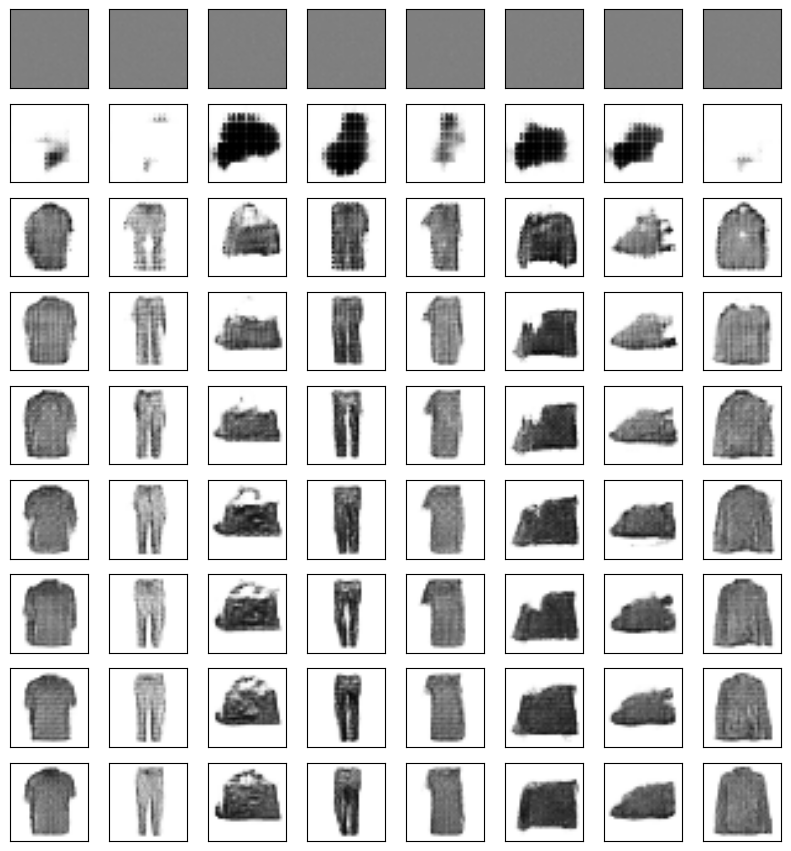

In [ ]:
def show_examples(examples):
    fig = plt.figure(figsize=(10, 1.2*len(examples)))
    c = 1
    for images in examples:
        for image in images:
            subplot = fig.add_subplot(len(examples), 8, c)
            subplot.set_xticks([])
            subplot.set_yticks([])
            subplot.imshow(image.reshape((32, 32)), vmin=0, vmax=1,
                           cmap=plt.cm.gray_r, interpolation='bilinear')
            c += 1

steps = (len(monitor.examples)-1) // 8
show_examples(monitor.examples[0:1] + monitor.examples[1::steps])

Generate new images with high discriminator scores.

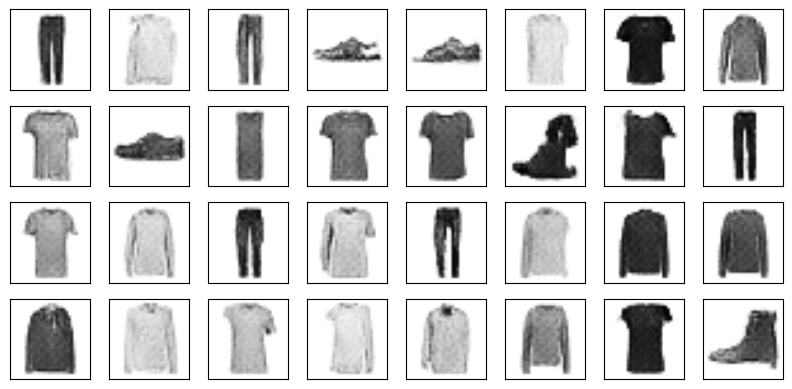

In [ ]:
sample_inputs = 0.7 * np.random.normal(size=(1024, latent_dim))
images = generator.predict(sample_inputs, verbose=0)
scores = discriminator.predict(images, verbose=0)
top_items = sorted(zip(images, scores), key=lambda x: x[1], reverse=True)
top_images = np.array([x[0] for x in top_items])
show_examples([top_images[0:8], top_images[8:16],
               top_images[16:24], top_images[24:32]])

Create morphing animation images.

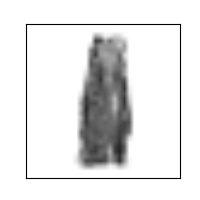

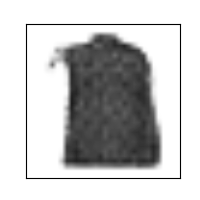

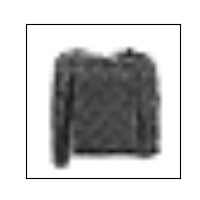

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display

def create_image(filename):
    x = 0.7 * np.random.normal(size=(3, latent_dim))
    inputs = []
    theta1, theta2 = 0, 0
    for _ in range(64):
        theta1 += 2*np.pi / 64 * 2
        theta2 += 2*np.pi / 64
        inputs.append(np.cos(theta1) * x[0] + \
           np.sin(theta1)*(np.cos(theta2)*x[1] + np.sin(theta2)*x[2]))
    res = generator.predict(np.array(inputs), verbose=0)

    def create_frame(i):
        subplot.cla()
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(res[i].reshape([32, 32]), vmin=0, vmax=1,
                       cmap=plt.cm.gray_r, interpolation='bilinear')

    fig = plt.figure(figsize=(2, 2))
    subplot = fig.add_subplot(1, 1, 1)
    ani = FuncAnimation(fig, create_frame, frames=range(64), interval=10)
    ani.save(filename)
    plt.clf()


for c in range(3):
    filename = f'DCGAN_morphing{c}.gif'
    create_image(filename)
    display(Image(filename, format='gif'))